In [1]:
import napari
import napari_workflows as nw
from skimage.io import imread
file_name = r'C:/Users/johan/Desktop/blobs.tif'
blobs = imread(file_name)

In [2]:
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow        
filename = 'workflow from napari.yaml'

loaded_wf = load_workflow(filename)
print(loaded_wf)

Workflow:
Result of Gaussian (scikit-image, nsbatwm) <- (<function gaussian_blur at 0x00000299D039FCA0>, 'blobs', 5.0)
Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm) <- (<function threshold_mean at 0x00000299D039F8B0>, 'Result of Gaussian (scikit-image, nsbatwm)')



In [3]:
import inspect
import magicgui
from functools import partial
from napari_tools_menu import make_gui
from inspect import Signature, signature
from functools import partial


def signature_w_kwargs_from_function(function, arg_vals: list) -> Signature:
    
    # getting the keywords corresponding to the values
    keyword_list = list(signature(function).parameters.keys())

    # creating the kwargs dict
    kw_dict = {}
    for kw, val in zip(keyword_list, arg_vals):
        kw_dict[kw] = val
    kw_dict.pop('image') # we are making an assumption that the input will aways be this
    
    sig = signature(partial(function, **kw_dict))
    
    return sig


In [4]:
roots = loaded_wf.roots()
roots

['blobs']

In [5]:
loaded_wf._tasks.items()

dict_items([('Result of Gaussian (scikit-image, nsbatwm)', (<function gaussian_blur at 0x00000299D039FCA0>, 'blobs', 5.0)), ('Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)', (<function threshold_mean at 0x00000299D039F8B0>, 'Result of Gaussian (scikit-image, nsbatwm)'))])

In [6]:
def wf_steps_with_root_as_input(workflow):
    roots = loaded_wf.roots()
    wf_step_with_rootinput = []
    for result, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source in roots:
                        wf_step_with_rootinput.append(result)
    return wf_step_with_rootinput

root_functions = wf_steps_with_root_as_input(loaded_wf)     
root_functions


['Result of Gaussian (scikit-image, nsbatwm)']

In [27]:
viewer3 = napari.Viewer()
viewer3.add_image(blobs)


workflow = loaded_wf
layers = viewer3.layers
old_to_new_name_mapping = {}

for i, wf_step_name in enumerate(root_functions):
    func = workflow._tasks[wf_step_name][0]
    args = workflow._tasks[wf_step_name][1:] 
    
    signat = signature_w_kwargs_from_function(func, args)
    func.__signature__ = signat
    widget = make_gui(func, viewer3)
    
    
    viewer3.window.add_dock_widget(widget)
    widget(layers[i].data)
    
    new_wf_step_name = 'Result of ' + func.__name__
    old_to_new_name_mapping[wf_step_name] = new_wf_step_name

# Do not forget to add name of roots to the directory
for root in loaded_wf.roots():
    old_to_new_name_mapping[root] = root

In [28]:
old_to_new_name_mapping

{'Result of Gaussian (scikit-image, nsbatwm)': 'Result of gaussian_blur',
 'blobs': 'blobs'}

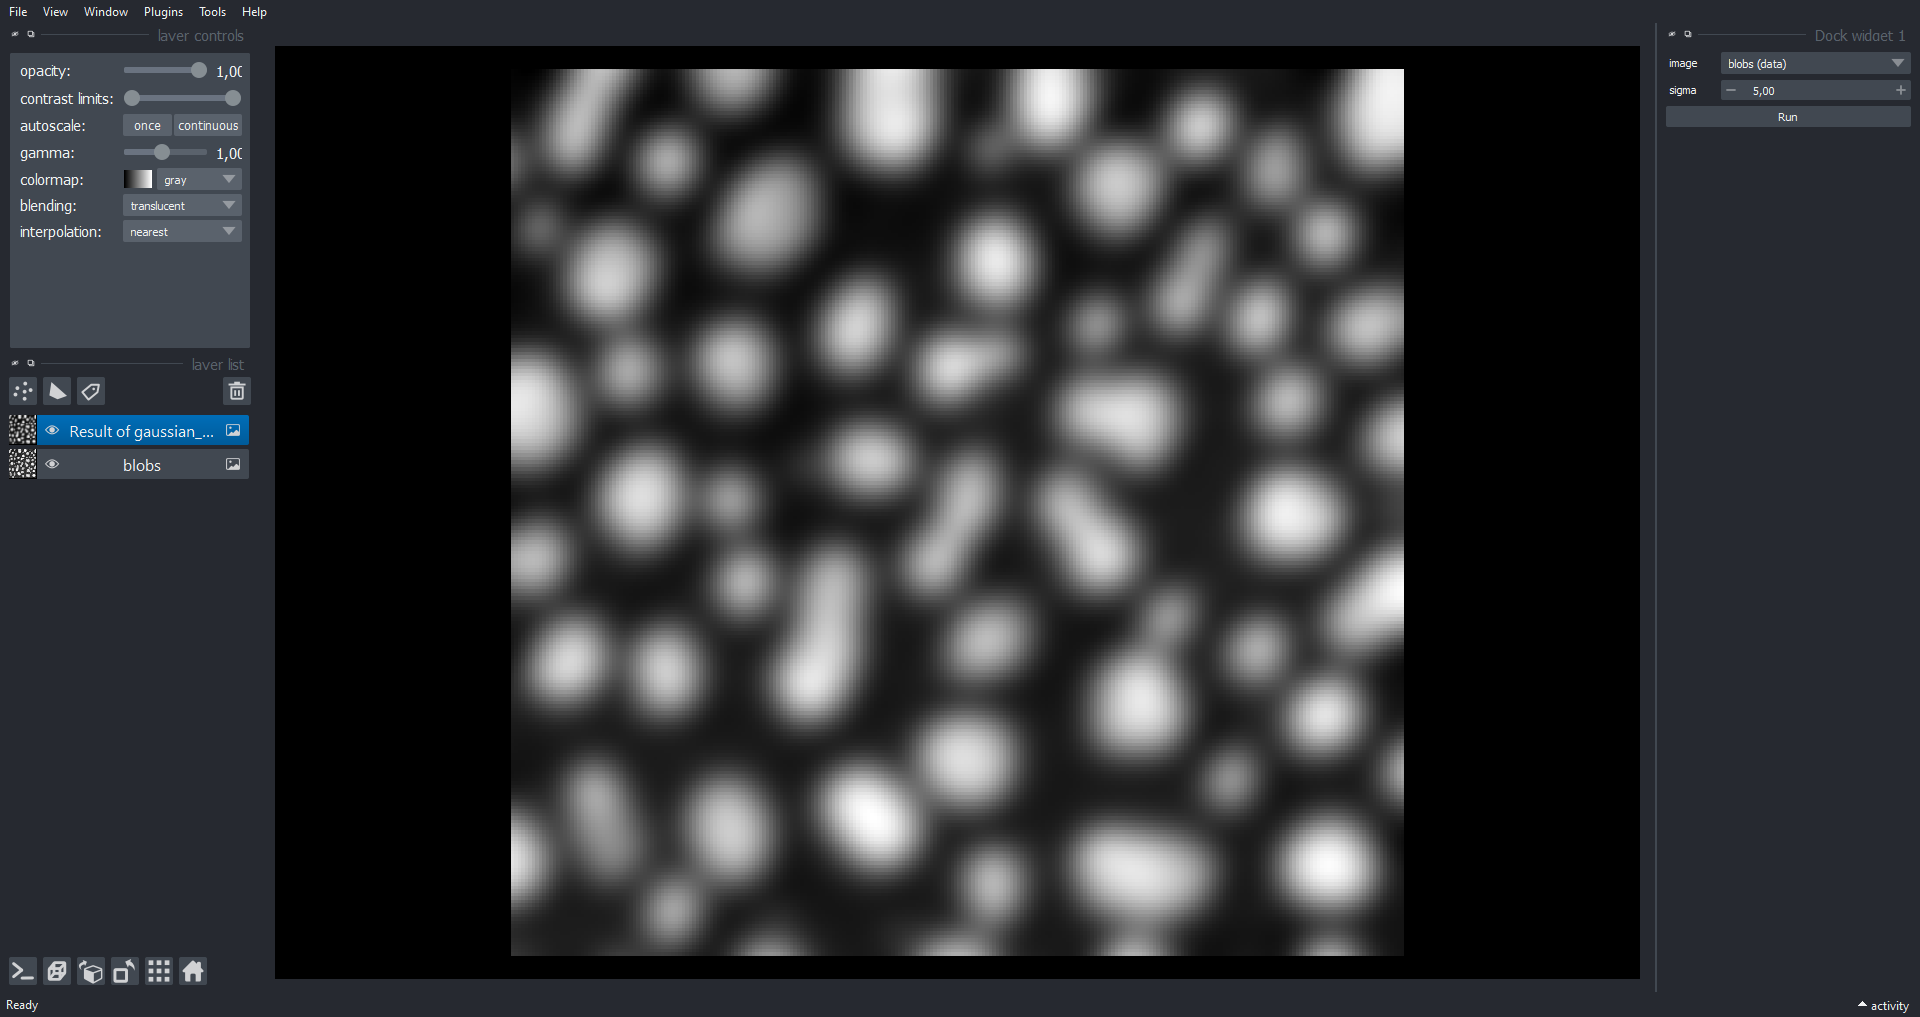

In [9]:
napari.utils.nbscreenshot(viewer3)

In [ ]:
wf_manager = nw.WorkflowManager.install(viewer3)
print(wf_manager.workflow)

In [58]:
viewer = napari.Viewer()
wf_manager = nw.WorkflowManager.install(viewer)
viewer.add_image(blobs)

<Image layer 'blobs' at 0x2998c62f4c0>

In [62]:
nodes = []

for key in loaded_wf._tasks.keys():
    nodes.append(key)
    
node_widget_dict = {}  # not ultimately necessary, just for later convenience
    
count_init = len(nodes)
for node in nodes:
    
    print('Checking ', node)
    
    # Check present layers in viewer
    names = [layer.name for layer in viewer.layers]
    source = loaded_wf.sources_of(node)[0]
    
    # prevent infinite loop
    if len(nodes) > count_init:
        break
    
    # Check if workflow step source is in list of layers.
    # If so, execute task. Else, append to list of nodes for later processing
    if old_to_new_name_mapping[source] in names:
        
        # Recreate function and widget only when all inputs exist
        func = loaded_wf._tasks[node][0]
        kwargs = loaded_wf._tasks[node][1:]

        signat = signature_w_kwargs_from_function(func, args)
        func.__signature__ = signat
        widget = make_gui(func, viewer)
        node_widget_dict[node] = widget  # add node/widget key/value pair to dictionary
        
        viewer.window.add_dock_widget(node_widget_dict[node])        
        node_widget_dict[node](layers[old_to_new_name_mapping[source]].data)
    else:
        nodes.append(node)
        

Checking  Result of Gaussian (scikit-image, nsbatwm)
Checking  Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)


In [60]:
wf_manager = nw.WorkflowManager.install(viewer)

In [61]:
wf_manager.workflow._tasks

{'Result of gaussian_blur': (<function napari_segment_blobs_and_things_with_membranes.gaussian_blur(image: <function NewType.<locals>.new_type at 0x00000299CC6CC670>, *, sigma: float = 5.0, viewer: napari.viewer.Viewer = None) -> <function NewType.<locals>.new_type at 0x00000299CC6CC670>>,
  'blobs',
  5.0,
  Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 126.5, 127.5), zoom=3.489566929133858, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=1, range=((0.0, 254.0, 1.0), (0.0, 256.0, 1.0)), current_step=(0, 0), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=-1, shape=(-1, -1), enabled=False), layers=[<Image layer 'blobs' at 0x2998c62f4c0>, <Image layer 'Result of gaussian_blur' at 0x299931554f0>, <Labels layer 'Result of threshold_mean' at 0x2998aa99c10>], 